In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit
import pickle as pkl
import pandas as pd

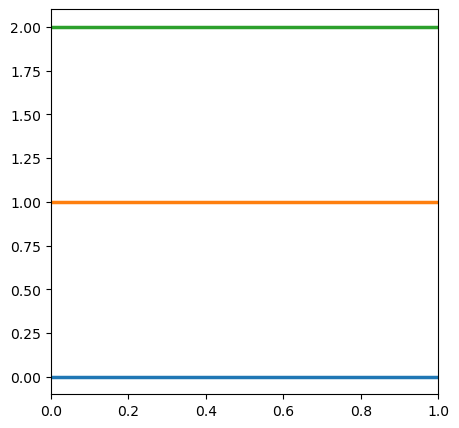

In [22]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

#new_cmap = ['#1F78B4','#FB9A99','#E31A1C']
new_cmap = ['tab:blue','tab:orange','tab:green']
rtg_r = LinearSegmentedColormap.from_list("rtg", new_cmap)
colors = rtg_r(np.linspace(0,1,3))

#Test colormap
fig = plt.figure(figsize=(5,5))

for i,color in enumerate(colors):
    plt.axhline(i, color=colors[i], linewidth=2.5)

In [23]:
systems = ['2PHES_150mMNaCl', 'TYR_PHE_150mMNaCl', '2TYRS_150mMNaCl', 'BUTYLAMMONIUM_ACETATE', 'GUANIDINE_ACETATE']
ffmods = ['Unmodified', 'PW', 'PP']

systems_plotname_alt = {'2PHES_150mMNaCl':'Phe-Phe',
                    'TYR_PHE_150mMNaCl':'Tyr-Phe',
                    '2TYRS_150mMNaCl':'Tyr-Tyr',
                    'BUTYLAMMONIUM_ACETATE':'Butylammonium-Acetate',
                    'GUANIDINE_ACETATE':'Guanidine-Acetate'}

systems_plotname = {'2PHES_150mMNaCl':'Phe-Phe',
                    'TYR_PHE_150mMNaCl':'Tyr-Phe',
                    '2TYRS_150mMNaCl':'Tyr-Tyr',
                    'BUTYLAMMONIUM_ACETATE':'Lys-Asp',
                    'GUANIDINE_ACETATE':'Arg-Asp'}

recalculate = False
RT=8.314e-3*300

#From Spriggs and Haake 1977
#and Christian and Tucker 1982
Ka_expt = {
    'BUTYLAMMONIUM_ACETATE':(0.31),
    'GUANIDINE_ACETATE':(0.37),
    '2PHES_150mMNaCl':(0.40),
    'TYR_PHE_150mMNaCl':(0.60)

}
systems_expt = Ka_expt.keys()

In [24]:
#Functions for saving and loading pickle files
def save_pickle(filename, pickle_obj):
    with open(filename, 'wb') as f:
        pkl.dump(pickle_obj, f)

def load_pickle(filename):
    with open(filename, 'rb') as f:
        loaded_obj = pkl.load(f)
        
    return loaded_obj

# PMF stuff

In [25]:
if recalculate == True:
    for system in systems:
        COMdist_hist_vs_sim = {}
        for ffmod in ffmods:
            print(f'Starting {system} {ffmod}')

            time, COMdist = np.genfromtxt(f'data/COMdist_{system}_{ffmod}.xvg', skip_header=17, usecols=(0,1), unpack=True)
            print('Loaded data')
            
            print(len(COMdist))
            
            #Make histogram of COM distance
            COMdist_hist_y, COMdist_hist_edges = np.histogram(COMdist_ent_corr, bins=100, density=True)
            COMdist_hist_x = []
            for i,edge in enumerate(COMdist_hist_edges[:-1]):
                bin_center = np.average([COMdist_hist_edges[i+1], edge])
                COMdist_hist_x.append(bin_center)
            COMdist_hist_x=np.array(COMdist_hist_x)
            print('Finished histogram')

            COMdist_hist_vs_sim[f'{system}_{ffmod}'] = [COMdist_hist_x, COMdist_hist_y]

        save_pickle(f'pickles/COMdist_hist_{system}.pkl', COMdist_hist_vs_sim)


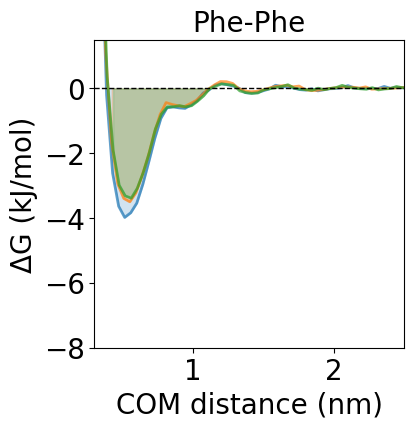

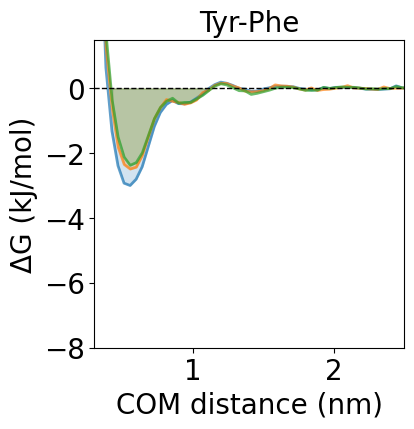

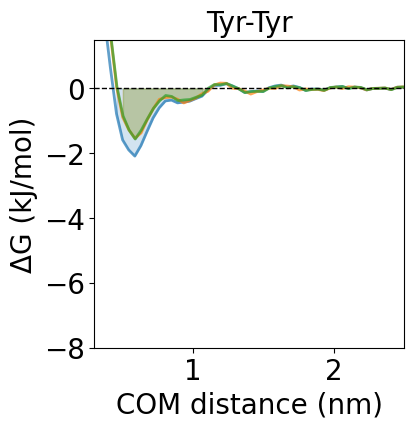

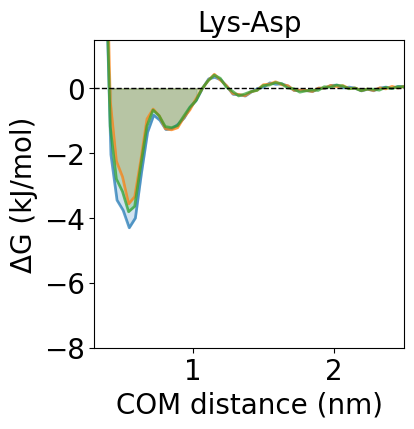

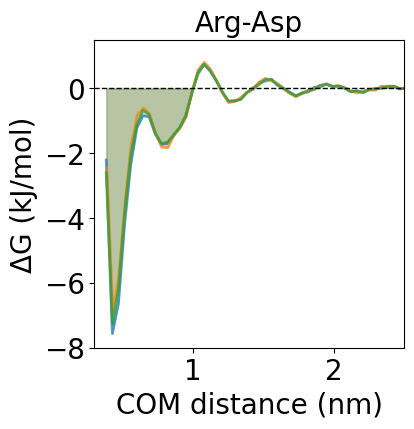

In [26]:
dG_vs_system = {}

for system in systems:
    COMdist_hist_vs_sim = load_pickle(f'pickles/COMdist_hist_{system}.pkl')
        
    fig = plt.figure(figsize=(4,4))
    
    for i,ffmod in enumerate(ffmods):
        
        COMdist_hist = COMdist_hist_vs_sim[f'{system}_{ffmod}']
        
        #Calculate free energy (in kBT) along COM distance as -ln(P) with an entropy correction in kJ/mol
        G = -np.log(COMdist_hist[1])*RT + 2*np.log(COMdist_hist[0])*RT
        G_offset = G-np.average(G[(COMdist_hist[0]>1.8)*(COMdist_hist[0]<2.5)])
                
        #Integrate PMF
        r_min = COMdist_hist[0][G_offset < 0][0]
        r_max = COMdist_hist[0][(G_offset > 0)*COMdist_hist[0]>r_min][0]
        idx = (COMdist_hist[0]<r_max)*(COMdist_hist[0]>=r_min)
        Kbind = np.trapz(4*np.pi*COMdist_hist[0][idx]*np.exp(-G_offset[idx]/RT), COMdist_hist[0][idx])
        dG0 = -RT*np.log(Kbind*(1/1.66))

        #Plot PMF
        plt.plot(COMdist_hist[0], G_offset, lw=2, alpha=0.7, c=colors[i])
        
        plt.fill_between(x=COMdist_hist[0][idx], y1=G_offset[idx], color= colors[i], alpha= 0.2)
        
        dG_vs_system[f'{system}_{ffmod}'] = dG0
        
    plt.title(systems_plotname[system], fontsize=20)
    plt.xlabel('COM distance (nm)', fontsize=20)
    #plt.ylabel('ΔG ($k_{B}T$)', fontsize=20)
    plt.ylabel('ΔG (kJ/mol)', fontsize=20)
    plt.tick_params(labelsize=20)
    
    #plt.axvline(half_box_diag, color='black', ls='--', lw=2)
    plt.axhline(0.0, color='black', lw=1, ls='--')
    
    plt.ylim(-8.0,1.5)
    plt.xlim(0.30,2.5)
    
    fig.savefig(f'../figures/{system}_PMF.png', bbox_inches='tight', pad_inches=1, dpi=400)
    fig.savefig(f'../figures/{system}_PMF.pdf', bbox_inches='tight', pad_inches=1, dpi=400)
    
save_pickle(f'pickles/dG_vs_system.pkl', dG_vs_system)


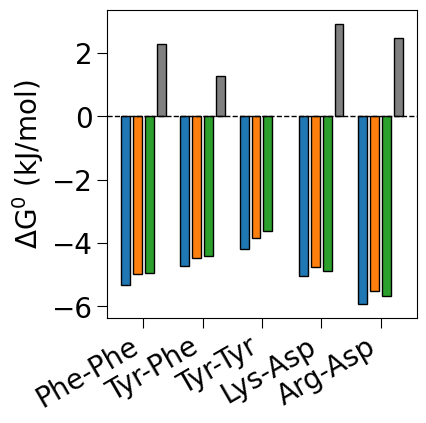

In [27]:
dG_vs_system = load_pickle(f'pickles/dG_vs_system.pkl')

#Plot data
fig= plt.figure(figsize=(4,4))

xtick_labels=[]
for i,system in enumerate(systems):
    xaxis = [i-0.30, i-0.10, i+0.10, i+0.30]

    for j,ffmod in enumerate(ffmods):
        dG = dG_vs_system[f'{system}_{ffmod}']    
                
        plt.bar(xaxis[j], dG, color=colors[j], width=0.15, edgecolor='black')

    if system in systems_expt:

        dG_expt = RT*np.log(1/(Ka_expt[system]))
        plt.bar(xaxis[3], dG_expt, color='gray', width=0.15, edgecolor='black')
        
    xtick_labels.append(systems_plotname[system])

plt.axhline(y=0, ls='--', c='black', lw=1)

plt.ylabel('ΔG$^0$ (kJ/mol)', fontsize=20)

plt.tick_params(colors='black', direction='out', length=7, labelsize=20)
plt.xticks(range(len(systems)), labels=xtick_labels, rotation=30, fontsize=20, ha='right')

fig.savefig(f"../figures/sidechainanalogues_dGbinding_vs_lambda.png", bbox_inches='tight', pad_inches=1, dpi=400)
fig.savefig(f"../figures/sidechainanalogues_dGbinding_vs_lambda.pdf", bbox_inches='tight', pad_inches=1, dpi=400)

# Check box volumes

In [6]:
systems_boxvol = ['2PHES_150mMNaCl', 'TYR_PHE_150mMNaCl']
boxvol_vs_system = {}

for system in systems_boxvol:
    for i,ffmod in enumerate(ffmods):
        print(f'Starting {system} {ffmod}')
        box_vol = np.genfromtxt(f'data/pVTE_{system}_{ffmod}.xvg', usecols=(4), unpack=True, skip_header=27)
        boxvol_vs_system[f'{system}_{ffmod}'] = np.average(box_vol)
save_pickle(f'pickles/boxvol_vs_system.pkl', boxvol_vs_system)


Starting 2PHES_150mMNaCl Unmodified
Starting 2PHES_150mMNaCl PW
Starting 2PHES_150mMNaCl PP
Starting TYR_PHE_150mMNaCl Unmodified
Starting TYR_PHE_150mMNaCl PW
Starting TYR_PHE_150mMNaCl PP


In [7]:
print(boxvol_vs_system)

{'2PHES_150mMNaCl_Unmodified': 1087.1265006436995, '2PHES_150mMNaCl_PW': 1087.119969741502, '2PHES_150mMNaCl_PP': 1087.1268102616639, 'TYR_PHE_150mMNaCl_Unmodified': 1087.2970428228314, 'TYR_PHE_150mMNaCl_PW': 1087.2869896375614, 'TYR_PHE_150mMNaCl_PP': 1087.2964440681242}


Tyr-Phe: 1087
2PHES: 1087



In [10]:
avogadros = 6.022e23
vol_liters = 1087.0*((10**-9)**3)*(10**3)
conc = ((2/avogadros)/vol_liters) #2 for two copies of the protein
print(f'{conc*1000}mM')

3.0553410875853237mM
